# Documenting *analysis* workflow using the Ebrains Knowledge Graph 

# --> provenance tracking using fairgraph

In [1]:
%%capture
!rm -rf fairgraph
!git clone https://github.com/yzerlaut/fairgraph.git # TEMPORARY 
!pip install -r ./fairgraph/requirements.txt
!pip install -U ./fairgraph
import os, sys, datetime
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

### A simple demo case: evaluating spiking rate from Vm traces

Given a set of Vm recording, the analysis determines the mean frequency of action potential firing.

In [2]:
# The the demo data and analysis source code are available in a public container at CSCS
container_url = 'https://object.cscs.ch/v1/AUTH_6ebec77683fb472f94d352be92b5a577/fairgraph_demo'
#### SCRIPT ####
if not os.path.isfile('analysis_script.py'):
   os.system('wget %s/analysis_script.py' % container_url)
#### DATA ####
os.system('wget %s/validation_data/Vm_data_10neurons_1000s.npz' % container_url)

2048

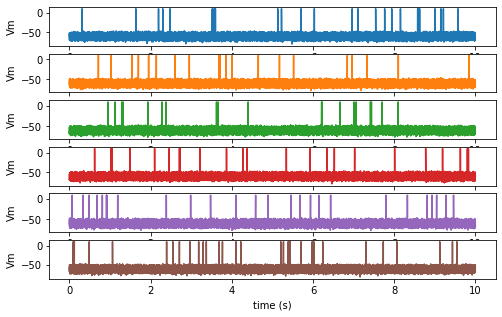

In [3]:
from analysis_script import plot_Vm_data
data = np.load('Vm_data_10neurons_1000s.npz', allow_pickle=True)
plot_Vm_data(data['Vm_traces'], data['args'].item(), tmax=10, Nmax=6);

## Setting up the client for the interaction with the KG

In [4]:
import os
from fairgraph import KGClient
# needs to have HBP_AUTH_TOKEN set as a bash variable !
# get your token at: https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize
dev = True
if dev:
    client = KGClient(os.environ["HBP_AUTH_TOKEN"],
                      nexus_endpoint='https://nexus-int.humanbrainproject.org/v0')
else:
    client = KGClient(os.environ["HBP_AUTH_TOKEN"])

## Analysis code / script

In [5]:
from fairgraph.analysis import AnalysisScript
from fairgraph.base import Distribution
## --> starting with script metadata underlying the model
analysis_script = AnalysisScript(name='Script for the determination of firing frequency from intracellular recordings',
                                 code_format='python',
                                 distribution=Distribution(container_url+'/analysis_script.py'),
                                 license='CC BY-SA')
analysis_script.save(client) # SAVE IN KG
print('The KG ID is:', analysis_script.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/emodelscript/v0.1.0/91ef88a9-97c0-4278-bd3a-a6676b16f22a


## Analysis parameters

In [6]:
from fairgraph.analysis import AnalysisConfiguration
from fairgraph.base import Distribution

Parameters = {'threshold_for_spike_detection_mV':-20.,
              'refractory_period_for_spike_detection_ms':1.}

import json
with open('spike_detection_parameters.json', 'w') as f:
    json.dump(Parameters, f)

analysis_config = AnalysisConfiguration(name='Parameter configuration for firing frequency analyis',
                                        json_description=''.join(['%s=%s ; ' % kv for kv in Parameters.items()]),
                                        config_file=Distribution('spike_detection_parameters.json'))
analysis_config.save(client)
print('The KG ID is:', analysis_config.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/analysisconfiguration/v0.0.1/515c0cfb-725e-4314-aa23-6062bc323f77


## Performing the analysis

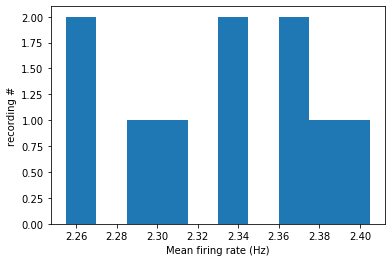

In [7]:
analysis_start_time = datetime.datetime.now()
from analysis_script import calculate_spiking_rate_from_Vm

args = data['args'].item()
t= np.arange(int(args['tstop']/args['dt']))*args['dt']

FiringRates = []
for i, vm in enumerate(data['Vm_traces']):
    fr = calculate_spiking_rate_from_Vm(t, vm,
                                        threshold=Parameters['threshold_for_spike_detection_mV'])
    FiringRates.append(fr)
np.save('mean_firing_rates.npy', FiringRates)

plt.hist(FiringRates)
plt.xlabel('Mean firing rate (Hz)')
plt.ylabel('recording #')
plt.gcf().savefig('mean_firing_rate_histogram.png')

analysis_end_time = datetime.datetime.now();

## Analysis results

In [8]:
from fairgraph.analysis import AnalysisResult

# for small files, we can store them directly on the knowledge graph
analysis_result = AnalysisResult(name='results of firing rate analysis in demo notebook',
                                 report_file='mean_firing_rates.npy',
                                 data_type = 'firing rate', 
                                 variable='spike',
                                 description='results of firing rate analysis in demo notebook')
analysis_result.save(client)
print('The KG ID is:', analysis_result.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/analysisresult/v0.0.1/0b01977c-4142-426f-912a-acdda806f75d


## Full Analysis Activity

In [9]:
from fairgraph.analysis import AnalysisActivity, Person

## --> agent
yann = Person(family_name='Zerlaut',
              given_name='Yann',
              email='yann.zerlaut@cnrs.fr')
yann.save(client)
print('The KG ID is:', yann.id)


## --> activity
sim = AnalysisActivity(name='parameter configuration of toy analysis in demo notebook',
                       description='',
                       configuration_used=analysis_config,
                       analysis_script=analysis_script,
                       timestamp=datetime.datetime.now(),
                       result = analysis_result,
                       started_by = yann,
                       started_at_time=analysis_start_time,
                       ended_at_time=analysis_end_time)

sim.save(client)
print('The KG ID is:', sim.id)

The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/core/person/v0.1.0/4be4449a-0e43-4746-a6c8-235236c530d0
The KG ID is: https://nexus-int.humanbrainproject.org/v0/data/modelvalidation/simulation/analysisactivity/v0.0.1/c5ed1bb7-9233-428e-a99b-0c2d85be2b32
